Nombre alumno: Ariel carvajal

#Openpose

Para la divulgación científica de algoritmos computacionales de alta complejidad la comunidad científica reconoce los canales típicos de publicación de artículos, como conferencias y revistas científicas. En ciertas oportunidades los autores presentan los códigos de sus trabajos tanto para darle más credibilidad a su publicación como para tratar de impresionar a sus lectores. Las herramientas públicas, como [Github](https://http://github.com/) han colaborado mucho como plataformas de distribución de código. Incluso muchos autodidactas han desarrollado aplicaciones interesantes, que pueden ser inicio de aplicaciones comerciales, a traves de los software de licencias libres y abiertas.<br>
El reconocimiento de poses es una tarea que cobra relevancia en aplicaciones como vigilancia, conducción autónoma de vehículos, y reconocimiento de acciones entre otros.<br>
La detección de esqueletos se concentra en aquellas partes del cuerpo que son más informativas para la definición de poses. Una buena manera de resolver este problema se logra a través de las redes completamente convolucionales.<br>
Típicamente, para utilizar un modelo preentrenado vamos a navegar la web buscando un repositorio con los códigos que sean de nuestro agrado. Luego de descargarla e instalarla vamos a bajar los pesos de la red, que suelen ser de algún tamaño considerable para estas plataformas de código. En este caso hemos encontrado una versión en pytroch de Openpose. 

In [ ]:
%%bash
git clone https://github.com/Hzzone/pytorch-openpose.git
wget -q https://www.dropbox.com/sh/7xbup2qsn7vvjxo/AABaYNMvvNVFRWqyDXl7KQUxa/body_pose_model.pth
wget -q https://www.dropbox.com/sh/7xbup2qsn7vvjxo/AAApu9PiOpzGYEUqzIzsxqbFa/hand_pose_model.pth
mv body_pose_model.pth pytorch-openpose/model/body_pose_model.pth
mv hand_pose_model.pth pytorch-openpose/model/hand_pose_model.pth
gdown --id 1gvqYJB8RVwOHAHa9jkkh7W3VEsMLHT7X
unzip Imagenes_para_poses.zip

Archive:  Imagenes_para_poses.zip
  inflating: 8736016-large-group-of-smiling-students-isolated-over-white-background.jpg  
  inflating: people-2557399_640.jpg  
  inflating: urban-438393_1920.jpg   


Cloning into 'pytorch-openpose'...
Downloading...
From: https://drive.google.com/uc?id=1gvqYJB8RVwOHAHa9jkkh7W3VEsMLHT7X
To: /content/Imagenes_para_poses.zip
100%|##########| 922k/922k [00:00<00:00, 59.4MB/s]


Muchas versiones tienen archivos de demostración o de finetuning. En la detección de poses no necesitamos hacer transferencia de conocimiento, detalle que veremos más adelante. Lo que sí nos interesa es el uso de estas redes. Como pocas veces los autores dejan disponible una extensa documentación, a excepción de aquellas aplicaciones más populares, lo que conviene hacer es estudiar los códigos de demostración. El siguiente es un ejemplo que fue construido con los cógidos de "demo.py".

In [ ]:
import cv2
import copy
import numpy as np
import sys
sys.path.append("pytorch-openpose")

from src import model
from src import util
from src.body import Body
from src.hand import Hand

body_estimation = Body('pytorch-openpose/model/body_pose_model.pth')
hand_estimation = Hand('pytorch-openpose/model/hand_pose_model.pth')

def anotateBody(img): #para la detección de un esqueleto completo
    candidate, subset = body_estimation(img)
    canvas = copy.deepcopy(img)
    canvas = util.draw_bodypose(canvas, candidate, subset)
    return canvas[:, :, [2, 1, 0]]

def anotateHand(img): #para la detección de las manos
    candidate, subset = body_estimation(img)
    canvas = copy.deepcopy(img)
    # canvas = util.draw_bodypose(canvas, candidate, subset)
    hands_list = util.handDetect(candidate, subset, img)

    all_hand_peaks = []
    for x, y, w, is_left in hands_list:
        peaks = hand_estimation(img[y:y+w, x:x+w, :])
        peaks[:, 0] = np.where(peaks[:, 0]==0, peaks[:, 0], peaks[:, 0]+x)
        peaks[:, 1] = np.where(peaks[:, 1]==0, peaks[:, 1], peaks[:, 1]+y)
        all_hand_peaks.append(peaks)

    canvas = util.draw_handpose(canvas, all_hand_peaks)

    return canvas[:, :, [2, 1, 0]]


El detector va a dibujar el esqueleto sobre la imágen. Este software puede trabajar detectanto tanto una versión general del esqueleto de la persona como de la mano. Veamos ambos ejemplos.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


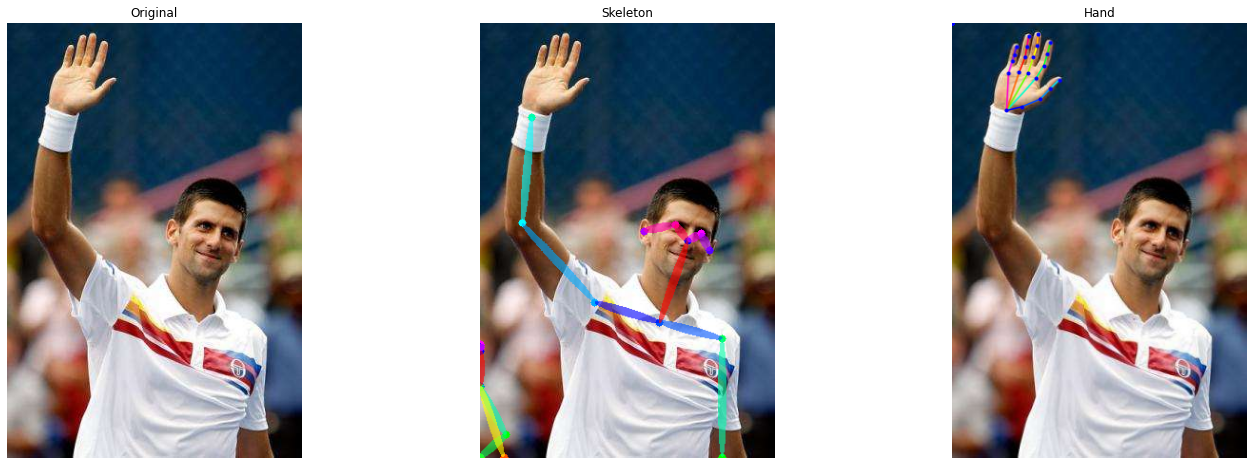

In [ ]:
import matplotlib.pyplot as plt

test_image = 'pytorch-openpose/images/demo.jpg'
oriImg = cv2.imread(test_image)  # B,G,R order

figure = plt.figure(figsize=(24,8))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(anotateBody(oriImg.copy()))
plt.title('Skeleton')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(anotateHand(oriImg.copy()))
plt.title('Hand')
plt.axis('off')
plt.show()

Típicamente estos detectores se centran en encontrar los puntos de articulación para los esqueletos. Luego proceden a unirlos según una cierta lógica en base a su conocimiento previo y los patrones que leen de sus entradas. El modelo de openpose arma el esqueleto con 18 puntos base.

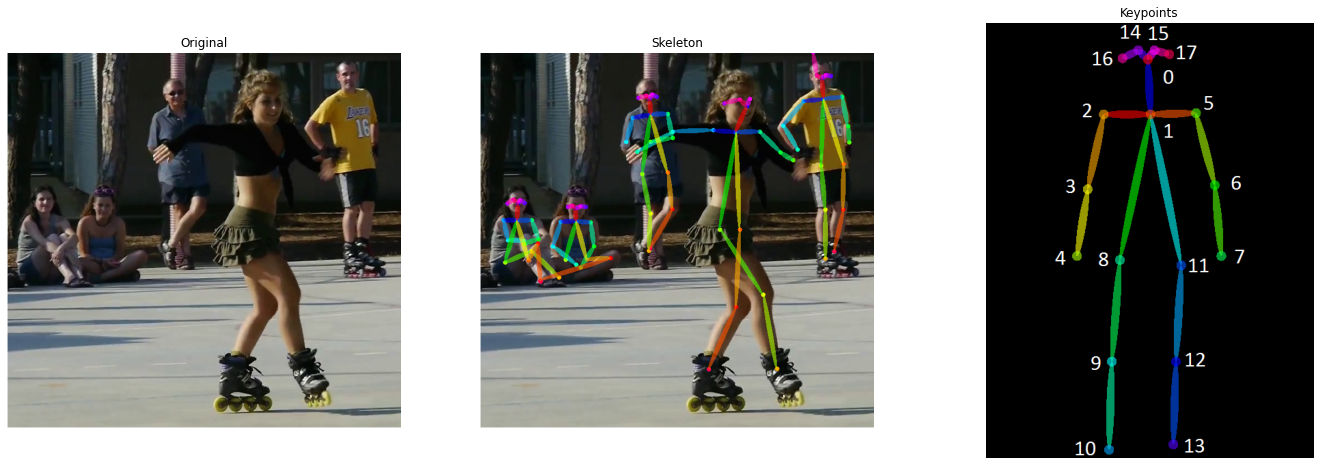

In [ ]:
test_image = 'pytorch-openpose/images/body_preview.jpg'
keypoints = 'pytorch-openpose/images/keypoints_pose_18.png'
oriImg = cv2.imread(test_image)[:, :710, :]
skeleton = cv2.imread(keypoints) 
figure = plt.figure(figsize=(24,8))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(anotateBody(oriImg))
plt.title('Skeleton')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(skeleton, cv2.COLOR_BGR2RGB))
plt.title('Keypoints')
plt.axis('off')
plt.show()

Como se puede apreciar puede detectar múltiples esqueletos en la imágen. <br>
Para la mano amplia la detección a 21 puntos.

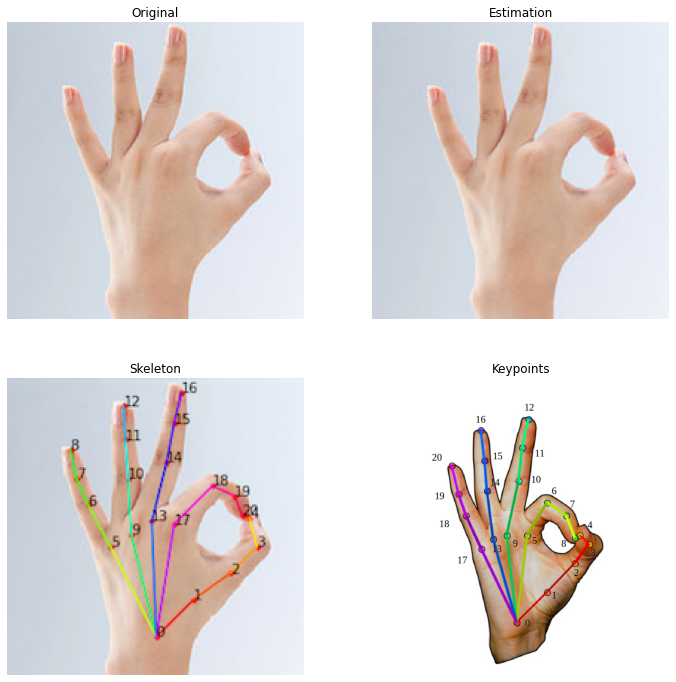

In [ ]:
test_image = 'pytorch-openpose/images/hand.jpg'
estimated = 'pytorch-openpose/images/hand_preview_estimation.png'
keypoints = 'pytorch-openpose/images/keypoints_hand.png'
oriImg = cv2.imread(test_image)
anotated = cv2.imread(estimated)
skeleton = cv2.imread(keypoints) 
figure = plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(anotateHand(oriImg))
plt.title('Estimation')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(cv2.cvtColor(anotated, cv2.COLOR_BGR2RGB))
plt.title('Skeleton')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(skeleton, cv2.COLOR_BGR2RGB))
plt.title('Keypoints')
plt.axis('off')
plt.show()

Nota, los autores especifican que para la detección de una mano requieren primero la estimación de la posición de la mano. No pueden hacer una detección en una fotografía de una mano directa ¿Por qué sucede esto?

#OpenPifPaf

Tradicionalmente el problema de la estimación de múltiples personas en imágenes 2D se puede realizar de dos maneras diferentes. La primera se denomina <i>top-down</i>, y se desarrolla primero detectando cada persona en la escena para luego identificar las junturas del esqueleto con este conocimiento previo. La segunda forma se conoce como <i>bottom-up</i>, esta metodología constará en detectar primero las junturas para luego agruparlas en una identidad o esqueleto.<br>
En esta oportunidad utilizaremos <i>Open Pifpaf</i>. Éste es un marco de trabajo del tipo <i>bottom-up</i>. Utiliza un módulo que fusiona un mapa de confianzas con un regresor de puntos claves PIF (<i>Part Intensity Fields</i>), en paralelo con otro regresor, PAF (<i>Part Assosiation Fields</i>), que agrupa los puntos encontrados en esqueletos. Con esta herramienta se pueden detectar los esqueletos de varias personas en una escena, con baja resolución o tamaño de objeto, y relativamente alta velocidad.  

In [ ]:
#El software es fácil de instalar, simplemente utilizamos pip
!pip install openpifpaf==0.10.1 #última versión estable conocida

     |████████████████████████████████| 189 kB 5.4 MB/s 
     |████████████████████████████████| 166 kB 42.0 MB/s 
     |████████████████████████████████| 1.4 MB 39.0 MB/s 
     |████████████████████████████████| 503 kB 48.4 MB/s 
  Created wheel for openpifpaf: filename=openpifpaf-0.10.1-cp37-cp37m-linux_x86_64.whl size=409265 sha256=ce283e7bb1c1d1fa0cd02a875fd3387a626adaa015c2cf90e12b7e53406454ba
  Stored in directory: /root/.cache/pip/wheels/46/dd/a3/88e2461d388c8f053b3735d67e971a7f885a7bff92b64d1a26
  Created wheel for pysparkling: filename=pysparkling-0.6.1-py3-none-any.whl size=187580 sha256=29a2094b5497aa92f4aa4c9191f48a3f8abd7276bbe3ae095aa488cd8640ee99
  Stored in directory: /root/.cache/pip/wheels/c8/2e/ac/5336e8ec240e9895bf4f142026f16d0d442af578d339c44aa0
Successfully built openpifpaf pysparkling
  Attempting uninstall: pytz
    Found existing installation: pytz 2018.9
    Uninstalling pytz-2018.9:
      Successfully uninstalled pytz-2018.9


In [ ]:
import openpifpaf
print("Versión actual de openpifpaf:", openpifpaf.__version__)

Versión actual de openpifpaf: 0.10.1


<H3>Analicemos una imagen</H3>
Vamos a estudiar la imagen "urban-438393_1920.jpg" que fue descomprimida junto a otras para esta experiencia.

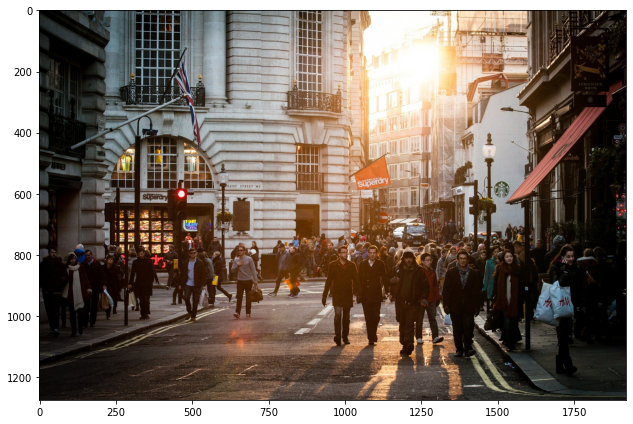

Tamaño de la imagen  (1275, 1920, 3)


In [ ]:
import io
import numpy as np
from PIL import Image
pil_im = Image.open('urban-438393_1920.jpg')
im = np.asarray(pil_im)
with openpifpaf.show.canvas() as ax: 
  ax.imshow(im)

print("Tamaño de la imagen ", im.shape)

Se trata de una imagen grande, de buena resolución, con personas en múltiples tamaños. Como PifPaf es una red completamente convolucional en principio se le puede alimentar de imágenes de cualquier tamaño. Veamos cómo funciona esto.<br>
A continuación vamos a cargar un modelo de PifPaf con columna vertebral de ResNet50. Recuerda trabajar con GPU para realizar cálculos más rápidos.

In [ ]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("usando " + "GPU" if use_cuda else "CPU")
oppnet, _ = openpifpaf.network.factory(checkpoint='resnet50')
oppnet = oppnet.to(device)
decode = openpifpaf.decoder.factory_decode(oppnet, 
                                           seed_threshold=0.5)
processor = openpifpaf.decoder.Processor(oppnet, decode, #detector que utilizaremos
                                         instance_threshold=0.2,
                                         keypoint_threshold=0.3)


usando GPU


Downloading: "https://github.com/vita-epfl/openpifpaf-torchhub/releases/download/v0.10.0/resnet50-pif-paf-paf25-edge401-191016-192503-d2b85396.pkl" to /root/.cache/torch/hub/checkpoints/resnet50-pif-paf-paf25-edge401-191016-192503-d2b85396.pkl


  0%|          | 0.00/102M [00:00<?, ?B/s]

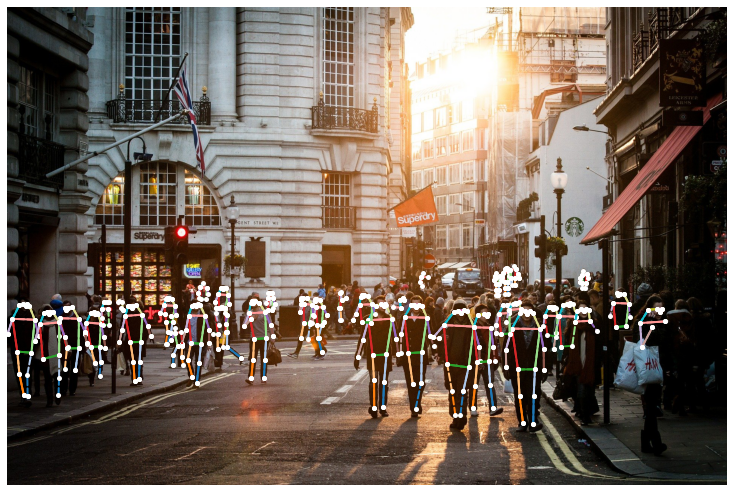

In [ ]:
data = openpifpaf.datasets.PilImageList([pil_im])
loader = torch.utils.data.DataLoader(data, batch_size=1, pin_memory=True)

keypoint_painter = openpifpaf.show.KeypointPainter(color_connections=True, linewidth=2)

for images_batch, _, __ in loader:
  images_batch = images_batch.cuda()
  fields_batch = processor.fields(images_batch)
  predictions = processor.annotations(fields_batch[0])
  
  with openpifpaf.show.image_canvas(im) as ax:
    keypoint_painter.annotations(ax, predictions)

Podemos apreciar una importante cantidad de detecciones, aunque el software no es perfecto. ¿A qué se debe?<br>
Para hacer predicciones con PifPaf nos interesa la red que denominamos como ```procesor```. Al ser una red completamente convolucional es lógico pensar que la salida tiene que ser una imagen. Sin embargo, los autores también desarrollaron otros métodos más utiles para trabajar con información compacta. En particular nos interesa el método ```keypoint_sets```.<br> 
Este método entrega como resultado una lista con las posiciones de todos los sets de puntos de cada esqueleto que encuentra, junto a una puntuación asignada a ellos. <br>
Hagamos un pequeño ejercicio ¿Cuántas personas se habrán encontrado en la imagen?.




In [ ]:
keypoint_sets, scores = processor.keypoint_sets(fields_batch[0])
print("La red encontró {} personas".format(len(keypoint_sets)))

La red encontró 38 personas


¿Cómo se presenta esta información?

In [ ]:
print(keypoint_sets.shape)

(38, 17, 3)


Efectivamente es bastante fácil contar la cantidad de personas que esta red encuentra, pero esta red entrega más información. La segunda dimensión del tensor es 17, esto quiere decir que hay 17 pares de puntos que conforman cada esqueleto en una predicción. Tales puntos se presentarían en este orden:<br>

<ol>
<li value="0"> Nariz </li>
<li> Ojo izquierdo </li>
<li> Ojo derecho </li>
<li> Oreja izquierda</li>
<li> Oreja derecha</li>
<li> Hombro izquierdo</li>
<li> Hombro derecho</li>
<li> Codo izquierdo</li>
<li> Codo derecho</li>
<li> Mano izquierda</li>
<li> Mano derecha</li>
<li> Cadera izquierda</li>
<li> Cadera derecha</li>
<li> Rodilla izquierda</li>
<li> Rodilla derecha</li>
<li> Pie izquierdo</li>
<li> Pie derecho</li>
</ol>

Pero la tercera dimensión del tensor es 3 ¿A qué corresponde el tercer valor? La documentación de este marco de trabajo no es tan precisa como para explicar este valor. Algunos de los que hemos trabajado con este software creemos que es un valor individual de puntaje que la red asigna a cada punto. 
<br>
Además, no todas las personas detectadas muestran todos los 17 puntos. Al igual que sucede con otros marcos de aprendizaje profundo la precisión no es algo completamente garantizado. La red intenta hacer una regresión para un modelo interno de esqueleto, lo que significa que debe dar algún valor a los puntos de su modelo. <br>
Veamos qué sucede cuando intenta predecir los puntos de una imagen que está cortada. Carga la imagen con nombre "people-2557399_640.jpg". 


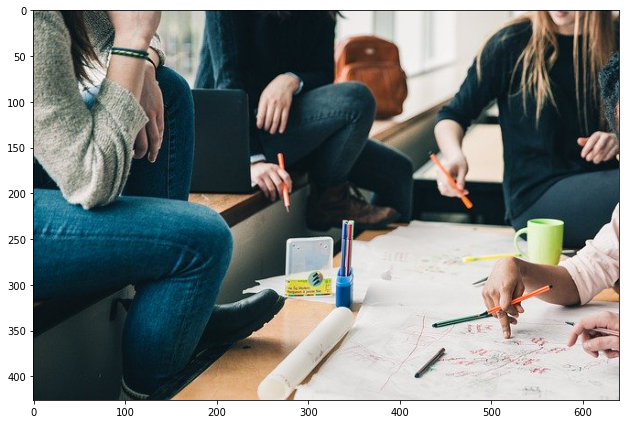

In [ ]:
pil_im = Image.open('people-2557399_640.jpg')
im = np.asarray(pil_im)
with openpifpaf.show.canvas() as ax:
  ax.imshow(im)

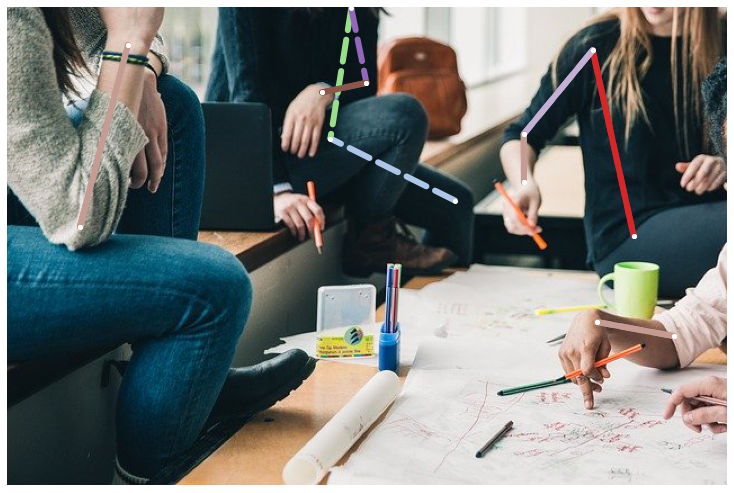

In [ ]:
data = openpifpaf.datasets.PilImageList([pil_im])
loader = torch.utils.data.DataLoader(data, batch_size=1, pin_memory=True)

keypoint_painter = openpifpaf.show.KeypointPainter(color_connections=True, linewidth=6)

for images_batch, _, __ in loader:
  images_batch = images_batch.cuda()
  fields_batch = processor.fields(images_batch)
  predictions = processor.annotations(fields_batch[0])
  keypoint_sets, scores = processor.keypoint_sets(fields_batch[0])
  
  with openpifpaf.show.image_canvas(im) as ax:
    keypoint_painter.annotations(ax, predictions)

La red puede identificar correctamente la cantidad de personas que hay en la escena, aunque estén muy ocluidas.

In [ ]:
print(keypoint_sets.shape)

(4, 17, 3)


¿Qué sucede con los puntos entonces?

In [ ]:
print(keypoint_sets)

[[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [5.20425781e+02 3.88514824e+01 8.87315333e-01]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [4.59149292e+02 1.13328270e+02 9.39996600e-01]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [4.59307251e+02 1.55882950e+02 8.86227369e-01]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [5.56806274e+02 2.03728989e+02 7.02224314e-01]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 

Muchos de ellos son instanciados a cero. Algunos incluso se muestran con una unión de lineas punteadas, probablemente debido al bajo valor de confianza que la red asigna. En versiones anteriores el software intentaba hacer predicciones fuera de la imagen. Actualmente el modelo es un poco más estricto con estos límites asignando a cero los valores no encontrados.<br>
 

#Clasificación de poses


Intentemos hacer algo más interesante. Carga el dataset miniMPII. Este dataset es un subconjunto de MPII con cuatro clases. Tiene pocas muestras por lo que puede llegar a ser desafiante para un modelo en profundidad.<br> 
En total posee 485 imágenes dividias en sets de entrenamiento, validación y test. Vamos a entrenar un perceptrón de 5 capas por 1000 épocas.

In [ ]:
!gdown --id 1Lg3Bsw4tFqye2rsentjLVK7eUw2qLLD3
!unzip -q mini_mpii.zip

Downloading...
From: https://drive.google.com/uc?id=1Lg3Bsw4tFqye2rsentjLVK7eUw2qLLD3
To: /content/mini_mpii.zip
100% 236M/236M [00:01<00:00, 171MB/s]


In [ ]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("usando " + "GPU" if use_cuda else "CPU")
oppnet, _ = openpifpaf.network.factory(checkpoint='resnet50')
oppnet = oppnet.to(device)
decode = openpifpaf.decoder.factory_decode(oppnet, 
                                           seed_threshold=0.5)
processor = openpifpaf.decoder.Processor(oppnet, decode, 
                                         instance_threshold=0.2,
                                         keypoint_threshold=0.3)

usando GPU


In [ ]:
#@title Dataset class
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np 
from PIL import Image
import csv
import cv2
import random
import sys

class PosesDataset(Dataset): #Clase dataset
    def __init__(self, path, oppnet, device): #Preprocesamos las imágenes con PifPaf para obtener el esqueleto
        self.classes = sorted(os.listdir(path))
        self.classesid = {class_nom : id for (id, class_nom) in enumerate(self.classes)}
        self.length_dataset = 0
        self.skeletons = []
        self.labels = []
        self.device = device
        self.bads_route = []

        for classdir in self.classes:
            samples = os.listdir(path + '/' + classdir)
            self.length_dataset += len(samples) #Actualizamos la cantidad de imágenes del dataset

        trim_ab = np.array([[1, 0], [0, 1], [0, 0]]) #para que solo las dos primeras columnas entren en el cálculo del centro de masa
        trim__c = np.array([[0], [0], [1]]) #para extraer tan solo la tercera columna en el cálculo matricial
        current = 0
        bad = 0

        for classdir in self.classes: #Bucar en cada clase
            samples = os.listdir(path + '/' + classdir)
            samples = sorted(samples)

            for sample in samples: #Cargar cada imagen de una clase en una lista o diccionario
                route = path + '/' + classdir + '/' + sample
                img = Image.open(route)
                width, height = img.size
                if width != 640 or height != 480:
                      img = img.resize((640, 480), resample=Image.BILINEAR)

                data = openpifpaf.datasets.PilImageList([img]) #Procesamos las imágenes en un minibatch que puede ser de largo variable
                loader = DataLoader(data, batch_size=1, pin_memory=True)

                curr = 0
                for images_batch, _, __ in loader:
                    curr += 1
                    images_batch = images_batch.to(device)
                    fields_batch = processor.fields(images_batch)
                    keypoint_sets, scores = processor.keypoint_sets(fields_batch[0])
                if curr > 1:
                    print('batch mayor a uno')

                width, height = 640, 480
                cm_img = np.array([[width/2, height/2]]) #Centro de masa según el tamaño actual
                distances = []
                mass_centers = []
                threshold = 0.5 #umbral de los puntos c de los que PifPaf no está seguro

                for skeleton in keypoint_sets:
                    cm_calc = np.around(skeleton.dot(trim__c)) #Mirando únicamente la tercera columna
                    cm_calc = (np.abs(cm_calc) >= threshold).astype(float) #Usando solo los más representativos (para que los que son cero no entren en el cálculo del centro de masa)
                    cm_calc = cm_calc/sum(cm_calc) #Matriz que calcula el centro de masa
                    cm_calc = cm_calc.transpose() #necesitamos transponer para multiplicar por la izquierda
                    cm = cm_calc.dot(skeleton).dot(trim_ab) #centro de masa de los puntos visibles
                    mass_centers.append(cm)
                    dist = np.linalg.norm(cm - cm_img)
                    distances.append(dist)
                    
                current += 1 #agregamos una imagen a la cuenta

                msj = "Sampling images in {} {:.2f}% complete".format(path, current/self.length_dataset*100)
                for i in range(len(msj)):
                    sys.stdout.write('\r')
                sys.stdout.write(msj)

                if len(distances) > 0:
                    index = np.argmin(np.array(distances)) #índice del esqueleto más centrado en la foto
                    label = self.classesid[classdir]
                    self.skeletons.append(keypoint_sets[index]) 
                    self.labels.append(label)
                else: #Como parte de la metodología hay imágenes que el software no puede guardar bien, pero están en el dataset. Estas se guardan.
                    self.skeletons.append(- torch.ones((17, 3))) 
                    self.labels.append(classesid[classdir])
                    self.bads_route.append(route)
                    bad += 1

        print(" ")
        if (bad > 0):
            print("Warning: there are {} images that PifPaf could not recognize, {:.2f}% of the total".format(bad, bad/current*100))

    def get_tags(self, idx=-1):
        if idx == -1:
            return list(self.classesid.keys())
        else:
            return self.classes[idx]

    def get_class_num(self, idx):
        return self.classesid[idx]

    def __getitem__(self, idx):
        skeleton = torch.tensor(self.skeletons[idx], requires_grad=True)
        label = torch.tensor(self.labels[idx])

        return skeleton.to(self.device).view(17*3), label.to(self.device)        

    def __len__(self):
        return self.length_dataset

In [ ]:
#@title plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
import time
import datetime
batch_size = 8
start = time.time()
train_set = PosesDataset('train', processor, device)
valid_set = PosesDataset('valid', processor, device)
test_set = PosesDataset('test', processor, device)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
stop = time.time()
print("Loading time = ", datetime.timedelta(seconds=int(stop-start)))

Sampling images in train 100.00% complete 
Sampling images in valid 100.00% complete 
Sampling images in test 100.00% complete 
Loading time =  0:02:22


¿Cuáles serían las clases de este set de datos?

In [ ]:
print(train_set.get_tags())

['bicycling', 'cooking', 'rope_skipping', 'washing_car']


Despleguemos un ejemplo de cada clase

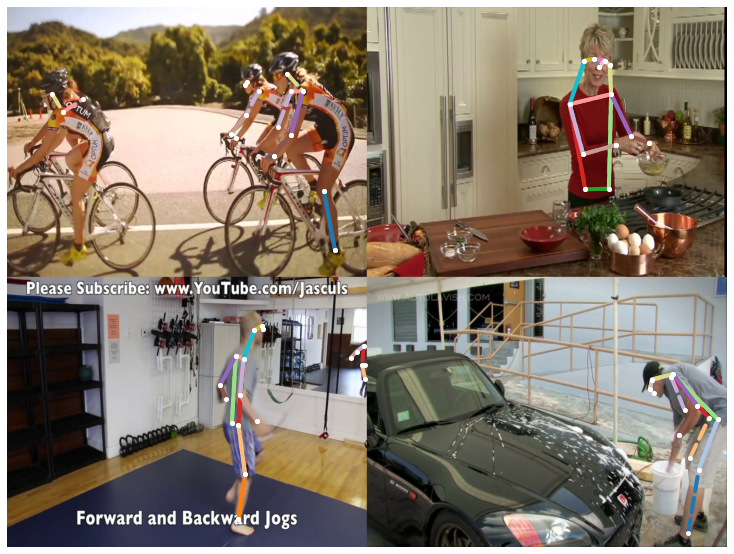

In [ ]:
import random
path = 'train'
classes = sorted(os.listdir(path))
classesid = {class_nom : id for (id, class_nom) in enumerate(classes)}

for (i, classdir) in enumerate(classes):
    samples = os.listdir(path + '/' + classdir)
    sampled = path + '/' + classdir + '/' + random.choice(samples)
    img_bgr = cv2.imread(sampled)
    height, width, channels = img_bgr.shape
    img_bgr = cv2.resize(img_bgr, (640, 480), interpolation=cv2.INTER_AREA)

    if i%2 == 0:
        row = img_bgr
    else:
        row = np.concatenate((row, img_bgr), axis=1)
        if i == 1:
            all_sampled = row
        else:
            all_sampled = np.concatenate((all_sampled, row), axis=0)

all_sampled = cv2.cvtColor(all_sampled, cv2.COLOR_BGR2RGB)
collage = Image.fromarray(all_sampled)
data = openpifpaf.datasets.PilImageList([collage])
loader = torch.utils.data.DataLoader(data, batch_size=1, pin_memory=True)

keypoint_painter = openpifpaf.show.KeypointPainter(color_connections=True, linewidth=4)

for images_batch, _, __ in loader:
  images_batch = images_batch.cuda()
  fields_batch = processor.fields(images_batch)
  predictions = processor.annotations(fields_batch[0])
  keypoint_sets, scores = processor.keypoint_sets(fields_batch[0])
  
  with openpifpaf.show.image_canvas(collage) as ax:
    keypoint_painter.annotations(ax, predictions)

In [ ]:
def epoch(model, loader, optimizer, criterion, train=True):
    if (train):
        model.train()
    else:
        model.eval()
        torch.no_grad()

    mean_loss = 0
    correct = 0

    Y_true = []
    Y_pred = []

    for (data, labels) in loader:
        prediction = model(data)
        optimizer.zero_grad()
        loss = criterion(prediction, labels)
        if (train):                  
            loss.backward()
            optimizer.step()
        mean_loss += loss.item()
        # correct += prediction.eq(torch.ones_like(labels)).sum().item()
        pred = prediction.argmax(dim=1, keepdim=True)
        # correct += pred[0].eq(labels).sum().item()
        yt = list(labels.cpu().numpy())
        yp = pred.cpu().numpy()
        yp = list(yp.reshape(len(yp)))        
        Y_true += yt
        Y_pred += yp

    epoch_loss = mean_loss/len(loader)
    # epoch_acc  = correct/len(loader)
    epoch_acc  = accuracy_score(Y_true, Y_pred)

    return epoch_loss, epoch_acc, Y_true, Y_pred

<H1>Agregar un clasificador con CNN que tome también el contexto</h1>

In [ ]:
Perceptron = nn.Sequential(
    nn.Linear(51, 128),
    nn.ReLU(),
    nn.Linear(128, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.4),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.4),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.4),
    nn.Linear(1024, 10),
    nn.Softmax(dim=1)
).to(device)
lossfn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(Perceptron.parameters(), lr=0.001)
optimizer = torch.optim.SGD(Perceptron.parameters(), lr=0.001)

nepochs = 1000
t_loss, t_acc, v_loss, v_acc = [], [], [], []
start = time.time()

for ep in range(nepochs):
    train_loss, train_acc, _, _ = epoch(Perceptron, train_loader, optimizer, lossfn, train=True)
    valid_loss, valid_acc, _, _ = epoch(Perceptron, valid_loader, optimizer, lossfn, train=False)
    t_loss.append(train_loss)
    t_acc.append(train_acc)
    v_loss.append(valid_loss)
    v_acc.append(valid_acc)

    msj = "Training {:.2f}% complete. Training loss {:.5f}, validation loss {:.5f}. Training accuracy {:.2f}, validation accuracy {:.2f}"
    msj = msj.format((ep+1)/nepochs*100, train_loss, valid_loss, train_acc, valid_acc)
    for i in range(len(msj)):
        sys.stdout.write('\r')
    sys.stdout.write(msj)

stop = time.time()
print(" ")
print("Training time = ", datetime.timedelta(seconds=int(stop-start)))

Training 100.00% complete. Training loss 1.71844, validation loss 1.76298. Training accuracy 0.76, validation accuracy 0.74 
Training time =  0:05:20


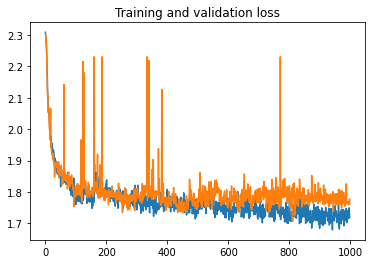

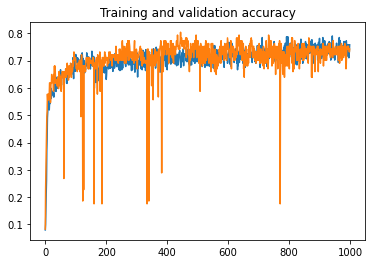

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(range(nepochs)), t_loss, list(range(nepochs)), v_loss)
plt.title('Training and validation loss')
plt.show()
plt.plot(list(range(nepochs)), t_acc, list(range(nepochs)), v_acc)
plt.title('Training and validation accuracy')
plt.show()

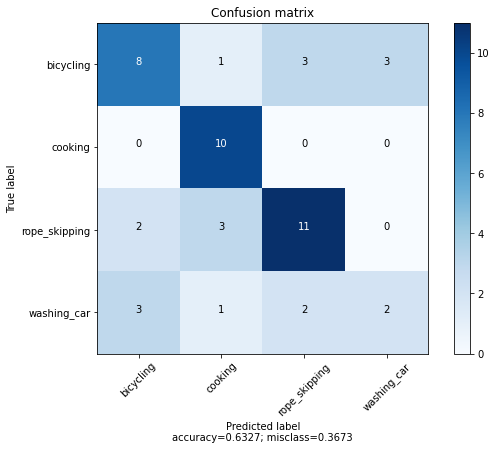

In [ ]:
test_loss, test_acc, y_true, y_pred = epoch(Perceptron, test_loader, optimizer, lossfn, train=False)
conf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_matrix, test_set.get_tags())

#Actividad

Navegue la web o sus redes sociales y seleccione 15 imágenes: 5 con una sola persona, 5 con 5 a 10 personas, 5 con múltiples personas (más de 20). Asegúrese de que todas las imágenes estén en un formato común: '.jpg', de 640x480. Si no lo están puede editarlas para que coincidan con lo que se desea (se pueden encontrar buenas imágenes gratuitas en [Pixabay](https://https://pixabay.com/), o utilizar la función ```cv2.resize()```).
<br> 
Cargue las imágenes, haga las respectivas detecciones de esqueleto utilizando PifPaf, y despliegue la cantidad de personas encontradas en cada imagen. <br>
Calcule el tiempo que se toma en procesar la información de cada grupo de 5 imágenes. Para ello utilice la librería ```Time```. <br>
<H3> 1) Reporte y comente las diferencias de tiempo para cada grupo.</H3><br> 
Nota, si la velocidad de cómputo es muy baja puede hacer repeticiones de un experimento. Por ejemplo: en un bucle calcule 100 veces los esqueletos de un grupo y tome ese tiempo de cómputo. Luego repita lo mismo con el siguiente grupo, y así sucesivamente. 

In [ ]:
diferencias_tiempo = '1.27, 1.33, 1.92 s para 1, \u003C5, >20 personas respectivamente' #@param {type:"string"}
print(diferencias_tiempo)

1.27, 1.33, 1.92 s para 1, <5, >20 personas respectivamente


<H3> 2) De sus imágenes seleccione una que posea personas en diferentes tamaños. Trate de visualizar las matrices de puntos que se extraen de PifPaf. ¿Qué diferencias de presición se pueden observar al crecer o disminuir los tamaños de las personas en las imágenes? </H3>

In [96]:
diferencias_presicion = 'Las personas peque\xF1as tienen puntos muy juntos (las diferencias entre coordenadas son menores ej: 0.1, 0.2, 0.3) en cambio las imagenes con \npersonas grandes tienen coordenadas con mayor magnitud (ej: 100, 200, 300). Las imagenes con personas mas pequeñas tienen tambien menor precisi\xF3n, \npor lo que no siempre coinciden los esqueletos con la imagen' #@param {type:"string"}
print(diferencias_presicion)

Las personas pequeñas tienen puntos muy juntos (las diferencias entre coordenadas son menores ej: 0.1, 0.2, 0.3) en cambio las imagenes con 
personas grandes tienen coordenadas con mayor magnitud (ej: 100, 200, 300). Las imagenes con personas mas pequeñas tienen tambien menor precisión, 
por lo que no siempre coinciden los esqueletos con la imagen


<H3>3) Si la matriz que entrega PifPaf tiene forma (n° esqueletos, 17, 3), donde la tercera dimensión se puede descomponer en (<i>x, y, c</i>). ¿Qué diferencias se aprecia en los promedios de <i>c</i> a lo largo de cada esqueleto? Comente comparando un esqueleto de una persona con gran tamaño en la imagen con una pequeña.</H3>


In [129]:
promedios_c = 'Al examinar los datos de C los que pertenecen a personas mas grandes (con respecto a la imagen) suelen variar mas que los que son para personas peque\xF1as,\n visualizando con el script de mas abajo pareciera que C está de alguna manera relaciona confianza de la prediccion, \nusualmente las caras tienen valores cercanos a 1' #@param {type:"string"}
print(promedios_c)

Al examinar los datos de C los que pertenecen a personas mas grandes (con respecto a la imagen) suelen variar mas que los que son para personas pequeñas,
 visualizando con el script de mas abajo pareciera que C está de alguna manera relaciona confianza de la prediccion, 
usualmente las caras tienen valores cercanos a 1


In [ ]:
import time
from statistics import mean

device = torch.device("cuda:0" if use_cuda else "cpu")
oppnet, _ = openpifpaf.network.factory(checkpoint='resnet50')
oppnet = oppnet.to(device)
decode = openpifpaf.decoder.factory_decode(
    oppnet, 
    seed_threshold=0.5
)

processor = openpifpaf.decoder.Processor(
    oppnet, 
    decode,
    instance_threshold=0.2,
    keypoint_threshold=0.3
)

In [ ]:
import random
#path = 'test_custom/1'
path = 'test_custom/5'
#path = 'test_custom/20'

images = []

for (i, img) in enumerate(sorted(os.listdir(path))):
    img_bgr = cv2.imread(f'{path}/{img}')
    resized = cv2.resize(img_bgr, (640, 480), interpolation=cv2.INTER_AREA)
    
    images.append(Image.fromarray(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)))



In [ ]:
data = openpifpaf.datasets.PilImageList(images)
loader = torch.utils.data.DataLoader(data, batch_size=1, pin_memory=True)

keypoint_painter = openpifpaf.show.KeypointPainter(color_connections=True, linewidth=2)

times = []
keypoints = []
#for _ in range(10):
  #start = time.time()
for i, (images_batch, _, __) in enumerate(loader):
  image_batch_cuda = images_batch.cuda()
  fields_batch = processor.fields(image_batch_cuda)
  predictions = processor.annotations(fields_batch[0])
  keypoint, scores = processor.keypoint_sets(fields_batch[0])
  keypoints.append(keypoint)
  print(keypoint)

  with openpifpaf.show.image_canvas(images[i]) as ax:
    keypoint_painter.annotations(ax, predictions)
  #end = time.time()
  #times.append(end - start)

#print(mean(times))

Output hidden; open in https://colab.research.google.com to view.

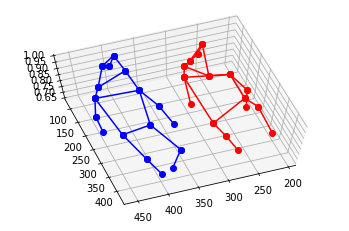

In [128]:
# DATOS DE LA IMAGEN https://pixabay.com/photos/children-portrait-siblings-brother-817368/

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# enumeracion para facilitar el acceso a los indices
nariz = 0
ojo_iz = 1
ojo_der = 2
oreja_iz = 3
oreja_der = 4
hombro_iz = 5
hombro_der = 6
codo_iz = 7
codo_der = 8
mano_iz = 9
mano_der = 10
cadera_iz = 11
cadera_der = 12
rodilla_iz = 13
rodilla_der = 14
pie_iz = 15
pie_der = 16

# Datos desde los keypoints 
data = np.array([
    [
        [400.55737    ,109.623184     ,0.93907696],
        [409.74622    ,100.50539      ,0.931322  ],
        [390.4987     ,101.16937      ,0.992427  ],
        [422.49692    ,104.1065       ,0.7778173 ],
        [376.56647    ,106.00917      ,0.86978245],
        [439.01486    ,154.65622      ,0.823634  ],
        [369.16577    ,159.94606      ,0.8244572 ],
        [453.223      ,214.79665      ,0.83154404],
        [354.62183    ,222.06573      ,0.8254433 ],
        [454.7788     ,265.9226       ,0.8259126 ],
        [344.05316    ,272.34274      ,0.77721995],
        [424.97177    ,264.0324       ,0.75592023],
        [379.18695    ,262.94174      ,0.786196  ],
        [408.05136    ,345.1615       ,0.719587  ],
        [346.8424     ,324.956        ,0.67368907],
        [402.8275     ,419.6          ,0.778563  ],
        [378.19336    ,391.45975      ,0.7176673 ],
    ], [
        [257.5148     , 97.767555     ,0.85851586],
        [268.47296    , 90.60246      ,0.7939666 ],
        [248.3045     , 88.677986     ,0.90499717],
        [280.57318    ,101.97172      ,0.7914974 ],
        [235.93005    , 94.38295      ,0.64252454],
        [295.4963     ,155.72307      ,0.83875275],
        [220.26086    ,157.23369      ,0.7826382 ],
        [299.25418    ,210.5539       ,0.7437522 ],
        [206.27298    ,209.86687      ,0.7582744 ],
        [  0.         ,  0.           ,0.        ],
        [217.54573    ,249.86069      ,0.7171637 ],
        [280.2152     ,277.93396      ,0.7157202 ],
        [233.20811    ,279.28424      ,0.88410604],
        [281.17502    ,353.29233      ,0.79165584],
        [236.62823    ,353.23898      ,1.        ],
        [281.9058     ,418.08887      ,0.8405464 ],
        [232.69301    ,421.54767      ,0.9460517 ],
    ],
])

# mapa para generar los vertices
conexiones = [
    (nariz,ojo_iz),
    (nariz,ojo_der),
    (ojo_iz,ojo_der),
    (ojo_iz,oreja_iz),
    (ojo_der,oreja_der),
    (oreja_iz,oreja_der),
    (hombro_iz,hombro_der),
    (oreja_iz,hombro_iz),
    (oreja_der,hombro_der),
    (hombro_iz,codo_iz),
    (codo_iz,mano_iz),
    (hombro_der,codo_der),
    (codo_der,mano_der),
    (cadera_iz,cadera_der),
    (hombro_iz,cadera_iz),
    (hombro_der,cadera_der),
    (cadera_iz,rodilla_iz),
    (cadera_der,rodilla_der),
    (rodilla_iz,pie_iz),
    (rodilla_der,pie_der),
]

for person, color in zip(data, ['blue', 'red', 'green']):
    for start, end in conexiones:
        points = person[[start, end], :] # extraer los valores para las secciones (ej mano-codo)
        
        if np.all(points): # no mostrar el vertice si tiene valores en 0
            ax.plot(
                points[:,0], 
                points[:,1],
                points[:,2], 
                'o-', 
                color=color
            )

ax.view_init(elev=70, azim=70)
plt.show()
